In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from metrics import eval_metrics_v1
from locata_utils import cart2sph

/users/PAS1937/battula12/my_pkgs/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /users/PAS1937/battula12/my_pkgs/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def get_log_dir(dataset_condition, noise_simulation, log_str):
    log_base_dir = '/fs/scratch/PAS0774/Shanmukh/ControlledExp/random_seg/'
    log_dir_task = f'{log_base_dir}/dbg_signals/simu_rirs_dbg_analysis/loss_functions_comparison_num_mics/{dataset_condition}/'
    if "noisy" in dataset_condition:
        log_dir = f'{log_dir_task}{noise_simulation}/'
    else:
        log_dir = log_dir_task

    _log_dir = f'{log_dir}{log_str}_corrected_doa_sig_norm/'

    if not os.path.exists(_log_dir):
        print("dir: {_log_dir} doesn't exist")

    return _log_dir

def get_log_str(dataset_condition, T60, SNR):
    if dataset_condition =="reverb":
        app_str = f't60_{T60}_comparison'
    elif dataset_condition =="noisy":
        app_str = f'snr_{SNR}dB'
    elif dataset_condition =="noisy_reverb":
        app_str = f't60_{T60}_snr_{SNR}dB'
    else:
        app_str = ''
    return app_str

def print_se_metrics(num_mics, _ch, est_d):
    print(f" enh: {num_mics}mic,  mic: {_ch}, SNR: {est_d['snr']:.2f}, SI_SNR: {est_d['si_snr']:.2f}, pesq_nb: {est_d['pesq_nb']:.2f}, pesq_wb: {est_d['pesq_wb']:.2f}, stoi: {est_d['stoi']:.4f}, e_stoi: {est_d['e_stoi']:.4f} ") 

In [4]:
dataset_condition, noise_simulation = "noisy", "point_source"
log_str = get_log_str(dataset_condition, 0.0, -5.0)
log_dir = get_log_dir(dataset_condition, noise_simulation, log_str)
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]

In [5]:
batch_idx = 0
idx, loss_flag = 2, "MIMO_RI_MAG_PD"

set_up = torch.load(f'/fs/scratch/PAS0774/Shanmukh/Controlled_Experimets/test_configs/source_moving/snr_-5_t60_0.2/src_mic_dist_1.0_noi_mic_dist_1.0/config_circular_motion_{batch_idx}.pt')
src_doa = np.degrees(cart2sph(set_up['src_traj_pts'][[0]] - set_up['array_pos']))[:,2]
noi_doa = np.degrees(cart2sph(set_up['noise_pos'] - set_up['array_pos']))[:,2]
print(f" src_doa: {src_doa}, noise_doa: {noi_doa}")

dir_content = os.listdir(log_dir)

mix_str, tgt_str = f'mix_{batch_idx}.wav', f'tgt_{batch_idx}.wav'
est_2mic_str = f'est_2mic_{batch_idx}_{idx}_{loss_flag}.wav'
est_4mic_str = f'est_4mic_{batch_idx}_{idx}_{loss_flag}.wav'

mix_sig, fs = torchaudio.load(os.path.join(log_dir, mix_str))
tgt_sig, fs = torchaudio.load(os.path.join(log_dir, tgt_str))
est_2mic_sig, fs = torchaudio.load(os.path.join(log_dir, est_2mic_str))
est_4mic_sig, fs = torchaudio.load(os.path.join(log_dir, est_4mic_str))

for _ch in range(4):
    est_d = eval_metrics_v1(tgt_sig[_ch,:].numpy(), est_4mic_sig[_ch,:].numpy())
    print_se_metrics(4, _ch, est_d)

for _ch in range(2):
    est_d = eval_metrics_v1(tgt_sig[_ch+1,:].numpy(), est_2mic_sig[_ch,:].numpy())
    print_se_metrics(2, _ch, est_d)

 src_doa: [75.], noise_doa: [-152.]
 enh: 4mic,  mic: 0, SNR: 14.56, SI_SNR: 14.43, pesq_nb: 2.96, pesq_wb: 1.85, stoi: 0.9658, e_stoi: 0.9152 
 enh: 4mic,  mic: 1, SNR: 15.80, SI_SNR: 15.73, pesq_nb: 3.12, pesq_wb: 1.92, stoi: 0.9705, e_stoi: 0.9221 
 enh: 4mic,  mic: 2, SNR: 16.34, SI_SNR: 16.29, pesq_nb: 3.20, pesq_wb: 1.92, stoi: 0.9725, e_stoi: 0.9289 
 enh: 4mic,  mic: 3, SNR: 14.95, SI_SNR: 14.82, pesq_nb: 3.00, pesq_wb: 1.85, stoi: 0.9679, e_stoi: 0.9182 
 enh: 2mic,  mic: 0, SNR: 9.76, SI_SNR: 9.70, pesq_nb: 2.60, pesq_wb: 1.66, stoi: 0.9424, e_stoi: 0.8777 
 enh: 2mic,  mic: 1, SNR: 10.01, SI_SNR: 9.92, pesq_nb: 2.64, pesq_wb: 1.67, stoi: 0.9420, e_stoi: 0.8759 


In [7]:
#observing pattern interms of SE for 2 mic vs 4mic for different loss functions
batch_idx = 0
#idx, loss_flag = 2, "MIMO_RI_MAG_PD"

set_up = torch.load(f'/fs/scratch/PAS0774/Shanmukh/Controlled_Experimets/test_configs/source_moving/snr_-5_t60_0.2/src_mic_dist_1.0_noi_mic_dist_1.0/config_circular_motion_{batch_idx}.pt')
src_doa = np.degrees(cart2sph(set_up['src_traj_pts'][[0]] - set_up['array_pos']))[:,2]
noi_doa = np.degrees(cart2sph(set_up['noise_pos'] - set_up['array_pos']))[:,2]
print(f" src_doa: {src_doa}, noise_doa: {noi_doa}")


#reading doa.pt file
doa_info = torch.load(os.path.join(log_dir, f'doa_{batch_idx}.pt'), map_location=torch.device('cpu'))

mix_str, tgt_str = f'mix_{batch_idx}.wav', f'tgt_{batch_idx}.wav'

mix_sig, fs = torchaudio.load(os.path.join(log_dir, mix_str))
tgt_sig, fs = torchaudio.load(os.path.join(log_dir, tgt_str))

for idx, loss_flag in enumerate(loss_list):
    print()
    est_2mic_str = f'est_2mic_{batch_idx}_{idx}_{loss_flag}.wav'
    if os.path.exists(os.path.join(log_dir, est_2mic_str)):
        est_2mic_sig, fs = torchaudio.load(os.path.join(log_dir, est_2mic_str))
        for _ch in range(2):
            est_d = eval_metrics_v1(tgt_sig[_ch+1,:].numpy(), est_2mic_sig[_ch,:].numpy())
            print_se_metrics(f'{loss_flag}_2', _ch, est_d)

    est_4mic_str = f'est_4mic_{batch_idx}_{idx}_{loss_flag}.wav' 
    est_4mic_sig, fs = torchaudio.load(os.path.join(log_dir, est_4mic_str))

    for _ch in range(4):
        est_d = eval_metrics_v1(tgt_sig[_ch,:].numpy(), est_4mic_sig[_ch,:].numpy())
        print_se_metrics(f'{loss_flag}_4', _ch, est_d)

    

 src_doa: [75.], noise_doa: [-152.]

 enh: MIMO_RI_2mic,  mic: 0, SNR: 7.67, SI_SNR: 7.17, pesq_nb: 2.47, pesq_wb: 1.31, stoi: 0.9092, e_stoi: 0.8203 
 enh: MIMO_RI_2mic,  mic: 1, SNR: 7.91, SI_SNR: 7.40, pesq_nb: 2.48, pesq_wb: 1.33, stoi: 0.9102, e_stoi: 0.8226 
 enh: MIMO_RI_4mic,  mic: 0, SNR: 15.46, SI_SNR: 15.34, pesq_nb: 3.05, pesq_wb: 1.90, stoi: 0.9674, e_stoi: 0.9225 
 enh: MIMO_RI_4mic,  mic: 1, SNR: 15.51, SI_SNR: 15.39, pesq_nb: 2.98, pesq_wb: 1.91, stoi: 0.9633, e_stoi: 0.9146 
 enh: MIMO_RI_4mic,  mic: 2, SNR: 15.90, SI_SNR: 15.79, pesq_nb: 3.02, pesq_wb: 1.91, stoi: 0.9669, e_stoi: 0.9213 
 enh: MIMO_RI_4mic,  mic: 3, SNR: 15.98, SI_SNR: 15.87, pesq_nb: 3.08, pesq_wb: 1.96, stoi: 0.9699, e_stoi: 0.9277 

 enh: MIMO_RI_MAG_2mic,  mic: 0, SNR: 9.18, SI_SNR: 9.13, pesq_nb: 2.57, pesq_wb: 1.53, stoi: 0.9356, e_stoi: 0.8649 
 enh: MIMO_RI_MAG_2mic,  mic: 1, SNR: 9.61, SI_SNR: 9.55, pesq_nb: 2.60, pesq_wb: 1.54, stoi: 0.9365, e_stoi: 0.8690 
 enh: MIMO_RI_MAG_4mic,  mic: 0, S

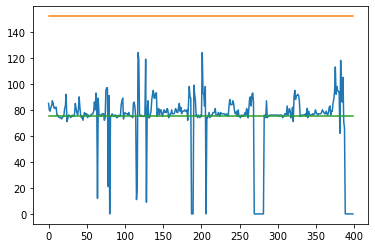

In [12]:
loss_flag = "MIMO_RI_PD"
(est_f_doa, est_f_vals, est_utt_doa) = doa_info['ests'][f'{loss_flag}_est_2mic_enh']
plt.plot(est_f_doa)
plt.plot(np.ones(est_f_doa.shape[0])*np.abs(noi_doa))
plt.plot(np.ones(est_f_doa.shape[0])*np.abs(src_doa))

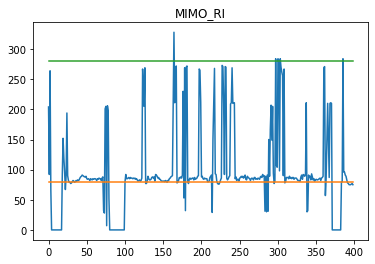

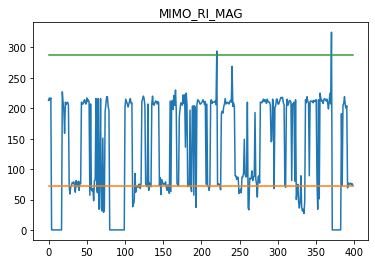

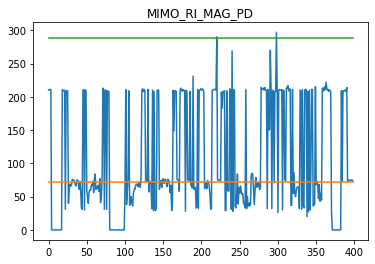

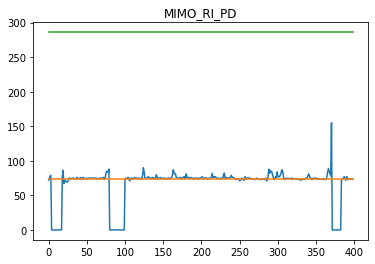

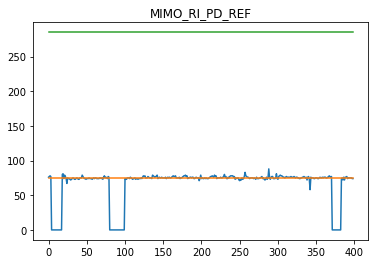

In [ ]:
#Circular Array doa pattern analysis
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD", "MIMO_RI_PD_REF"]
